In [1]:
!pip install -q kaggle tensorflow scikit-learn matplotlib split-folders wandb

In [3]:
import os

# Set Kaggle credentials
os.environ['KAGGLE_USERNAME'] = 'aman0515643'
os.environ['KAGGLE_KEY'] = '6e3968bcf2f527f0a31d6fac7244c631'

# Download dataset
!kaggle datasets download -d aman0515643/pomegranate-disease
!unzip -q pomegranate-disease.zip -d pomegranate_data

Dataset URL: https://www.kaggle.com/datasets/aman0515643/pomegranate-disease
License(s): CC0-1.0
 99% 2.48G/2.49G [00:17<00:00, 235MB/s]
100% 2.49G/2.49G [00:17<00:00, 155MB/s]


In [7]:
import os
print(os.listdir('pomegranate_data'))

['Pomegranate']


In [8]:
# Split dataset (60% train, 40% test)
import splitfolders
splitfolders.ratio(
    'pomegranate_data/Pomegranate',
    output="split_data",
    seed=42,
    ratio=(0.6, 0.4),
    group_prefix=None
)

Copying files: 3000 files [00:16, 184.83 files/s]


In [9]:
train_dir = 'split_data/train'
test_dir = 'split_data/test'

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)  # EFDDNN-EI typically uses 224x224
BATCH_SIZE = 32

In [11]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [12]:
# Test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1800 images belonging to 5 classes.


In [15]:
import shutil
import os

if os.path.exists('split_data'):
    shutil.rmtree('split_data')

In [16]:
# Split dataset (60% train, 40% test)
import splitfolders
splitfolders.ratio(
    'pomegranate_data/Pomegranate',
    output="split_data",
    seed=42,
    ratio=(0.6, 0.4),
    group_prefix=None
)

Copying files: 3000 files [00:18, 161.97 files/s]


In [17]:
import os

base_dir = 'split_data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create base and train/test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get class names from the original data directory
class_names = os.listdir('pomegranate_data/Pomegranate')

# Create class subdirectories within train and test directories
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

print(f"Created directories: {train_dir}, {test_dir} and class subdirectories.")

Created directories: split_data/train, split_data/test and class subdirectories.


In [18]:
# Split dataset (60% train, 40% test)
import splitfolders
splitfolders.ratio(
    'pomegranate_data/Pomegranate',
    output="split_data",
    seed=42,
    ratio=(0.6, 0.4),
    group_prefix=None
)

Copying files: 3000 files [00:10, 296.96 files/s]


In [19]:
# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 0 images belonging to 5 classes.


In [20]:
import random
import shutil

base_data_dir = 'pomegranate_data/Pomegranate'
train_dir = 'split_data/train'
test_dir = 'split_data/test'
train_ratio = 0.6
test_ratio = 0.4

all_files = []
for class_name in os.listdir(base_data_dir):
    class_path = os.path.join(base_data_dir, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            all_files.append(os.path.join(class_path, img_file))

random.shuffle(all_files)

train_count = 0
test_count = 0

for file_path in all_files:
    class_name = os.path.basename(os.path.dirname(file_path))

    if random.random() < train_ratio:
        destination_dir = os.path.join(train_dir, class_name)
        shutil.copy(file_path, destination_dir)
        train_count += 1
    else:
        destination_dir = os.path.join(test_dir, class_name)
        shutil.copy(file_path, destination_dir)
        test_count += 1

print(f"Total files: {len(all_files)}")
print(f"Copied to train: {train_count}")
print(f"Copied to test: {test_count}")


Total files: 3000
Copied to train: 1792
Copied to test: 1208


In [21]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1208 images belonging to 5 classes.


In [22]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1208 images belonging to 5 classes.


In [23]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_efddnn_ei(input_shape=(224, 224, 3), num_classes=num_classes):
    inputs = Input(shape=input_shape)

    # Enhanced Feature Extraction Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Deep Neural Network with Early Integration
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_efddnn_ei()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,266,181 (393.93 MB)

 Trainable params: 103,265,285 (393.93 MB)

 Non-trainable params: 896 (3.50 KB)

In [27]:
import os

base_dir = 'split_data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create base and train/test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get class names from the original data directory
class_names = os.listdir('pomegranate_data/Pomegranate')

# Create class subdirectories within train and test directories
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

print(f"Created directories: {train_dir}, {test_dir} and class subdirectories.")

Created directories: split_data/train, split_data/test and class subdirectories.


In [28]:
import random
import shutil

base_data_dir = 'pomegranate_data/Pomegranate'
train_dir = 'split_data/train'
test_dir = 'split_data/test'
train_ratio = 0.6
test_ratio = 0.4

all_files = []
for class_name in os.listdir(base_data_dir):
    class_path = os.path.join(base_data_dir, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            all_files.append(os.path.join(class_path, img_file))

random.shuffle(all_files)

train_count = 0
test_count = 0

for file_path in all_files:
    class_name = os.path.basename(os.path.dirname(file_path))

    if random.random() < train_ratio:
        destination_dir = os.path.join(train_dir, class_name)
        shutil.copy(file_path, destination_dir)
        train_count += 1
    else:
        destination_dir = os.path.join(test_dir, class_name)
        shutil.copy(file_path, destination_dir)
        test_count += 1

print(f"Total files: {len(all_files)}")
print(f"Copied to train: {train_count}")
print(f"Copied to test: {test_count}")

Total files: 3000
Copied to train: 1777
Copied to test: 1223


In [29]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1930 images belonging to 5 classes.


In [31]:
EPOCHS = 10  # You can adjust the number of epochs

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.4619 - loss: 31.8972 - val_accuracy: 0.3337 - val_loss: 33.9412
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.6295 - loss: 17.1254 - val_accuracy: 0.1984 - val_loss: 134.4387
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.6968 - loss: 12.7807 - val_accuracy: 0.3373 - val_loss: 28.7478
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.7581 - loss: 7.5476 - val_accuracy: 0.3648 - val_loss: 20.9426
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.7500 - loss: 6.5277 - val_accuracy: 0.2544 - val_loss: 59.6862
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.7695 - loss: 4.8662 - val_accuracy: 0.2140 - val_loss: 45.5913
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.7934 - loss: 3.3695 - val_accuracy: 0.4415 - val_loss: 13.2823
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.8368 - loss: 2.3361 - val_accuracy:

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stop]
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.8417 - loss: 1.1589 - val_accuracy: 0.6906 - val_loss: 1.0710
Epoch 2/10
 1/56 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.7500 - loss: 2.2598

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


56/56 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7500 - loss: 2.2598 - val_accuracy: 0.7125 - val_loss: 0.9302
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.8243 - loss: 1.0877 - val_accuracy: 0.8464 - val_loss: 0.8551
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9375 - loss: 0.3806 - val_accuracy: 0.8573 - val_loss: 0.7678
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - accuracy: 0.8479 - loss: 1.0221 - val_accuracy: 0.8656 - val_loss: 0.5470
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.7812 - loss: 0.7231 - val_accuracy: 0.8938 - val_loss: 0.4259
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.8177 - loss: 0.9914 - val_accuracy: 0.6927 - val_loss: 1.2907
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8125 - loss: 0.9758 - val_accuracy: 0.6990 - val_loss: 1.2465
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.8458 - loss: 0.7836 - val_accuracy: 0.8854 - val_loss: 0.3

In [34]:
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

print(f"Training Accuracy: {train_acc:.4f} | Training Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Training Accuracy: 0.8783 | Training Loss: 0.3642
Test Accuracy: 0.8850 | Test Loss: 0.3520


61/61 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step


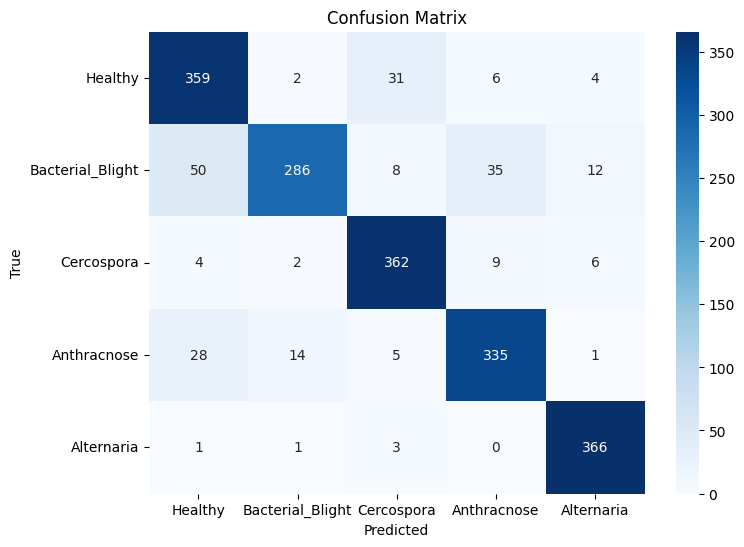

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [36]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.81      0.89      0.85       402
Bacterial_Blight       0.94      0.73      0.82       391
      Cercospora       0.89      0.95      0.91       383
     Anthracnose       0.87      0.87      0.87       383
      Alternaria       0.94      0.99      0.96       371

        accuracy                           0.88      1930
       macro avg       0.89      0.89      0.88      1930
    weighted avg       0.89      0.88      0.88      1930



In [37]:
from sklearn.metrics import f1_score

f1_scores = f1_score(y_true, y_pred_classes, average=None)
for cls, score in zip(class_names, f1_scores):
    print(f"{cls}: {score:.4f}")

Healthy: 0.8507
Bacterial_Blight: 0.8218
Cercospora: 0.9141
Anthracnose: 0.8724
Alternaria: 0.9632


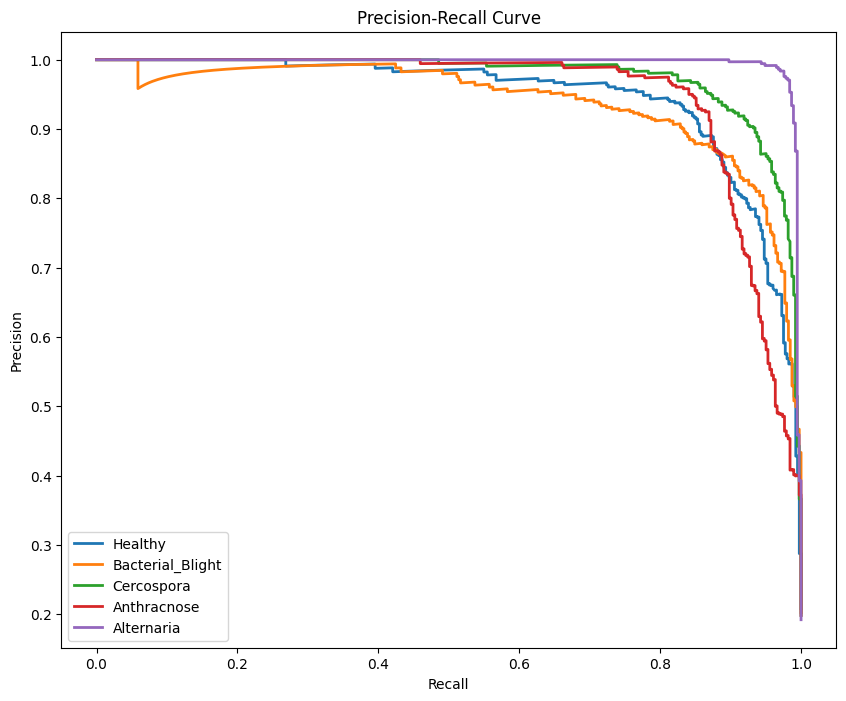

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


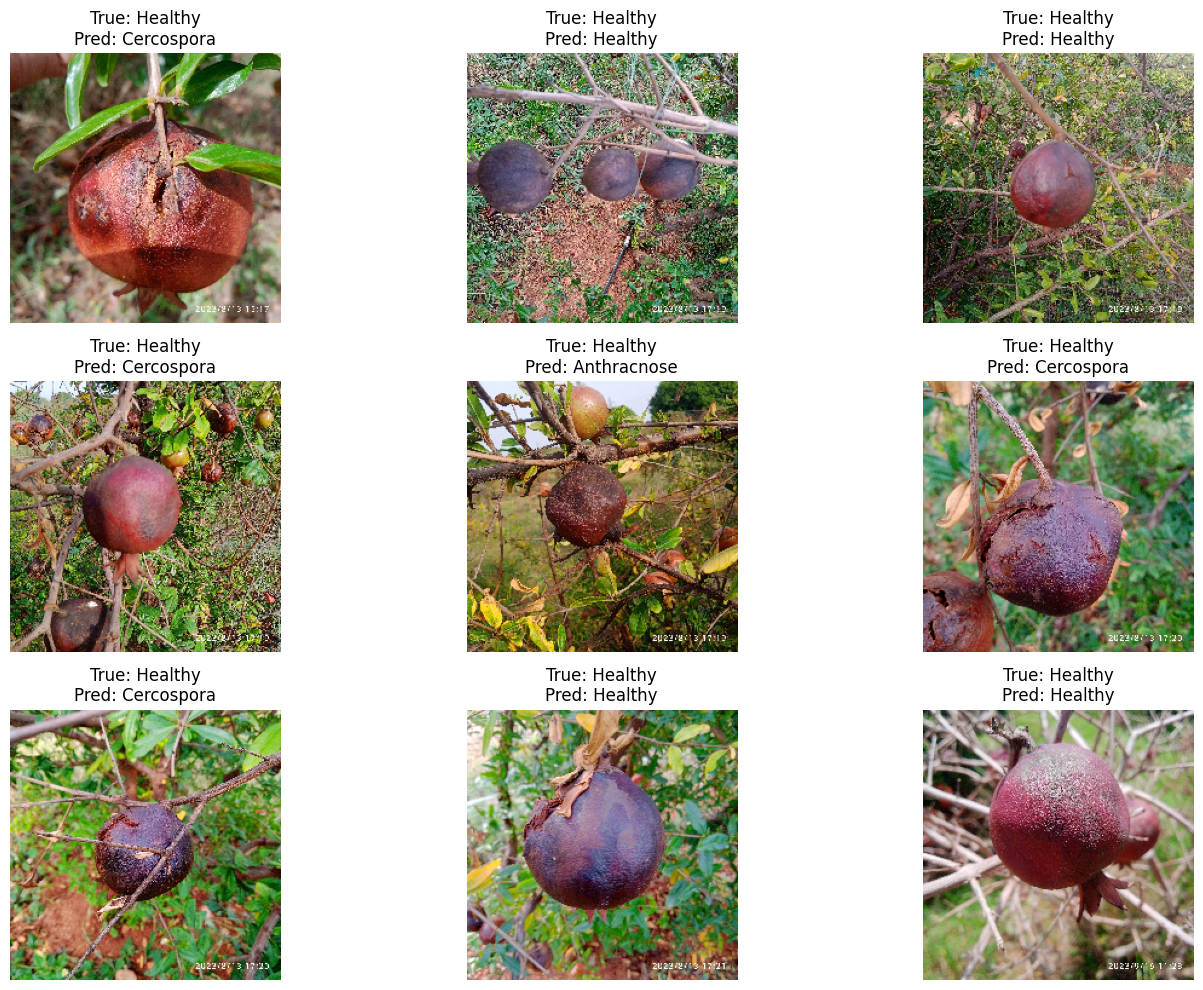

In [39]:
sample_images, sample_labels = next(test_generator)
sample_preds = model.predict(sample_images)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {class_names[sample_true_classes[i]]}\nPred: {class_names[sample_pred_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [40]:
model.save('efddnn_ei_pomegranate.h5')
print("Model saved as 'efddnn_ei_pomegranate.h5'")

Model saved as 'efddnn_ei_pomegranate.h5'


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


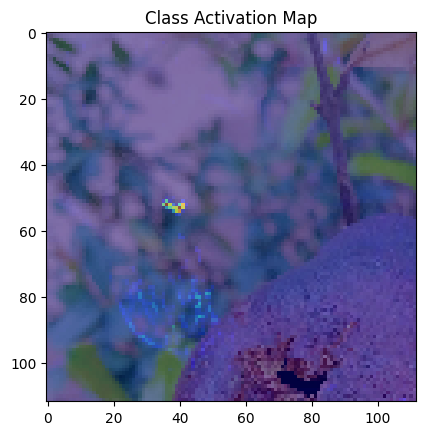

In [42]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

def generate_cam(img_array, model, last_conv_layer_name='conv2d_2'):
    grad_model = Model(inputs=model.inputs,
                     outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1).numpy()[0]
    return np.maximum(cam, 0) / np.max(cam)

sample_img = next(test_generator)[0][0]
cam = generate_cam(np.expand_dims(sample_img, axis=0), model)
plt.imshow(sample_img)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title('Class Activation Map')
plt.show()

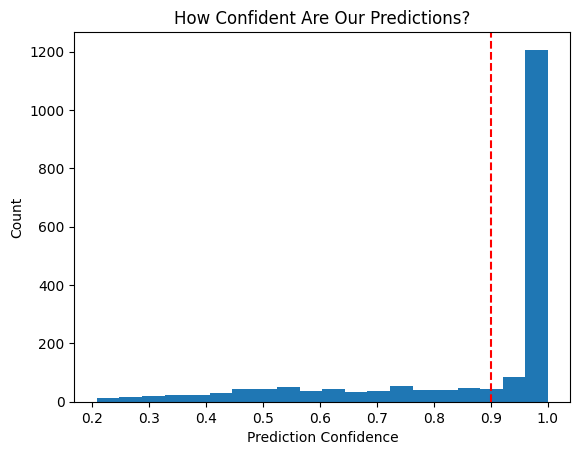

In [43]:
plt.hist(np.max(y_pred, axis=1), bins=20)
plt.axvline(x=0.9, color='r', linestyle='--')
plt.xlabel('Prediction Confidence')
plt.ylabel('Count')
plt.title('How Confident Are Our Predictions?')
plt.show()

218 samples were correct but with <70% confidence


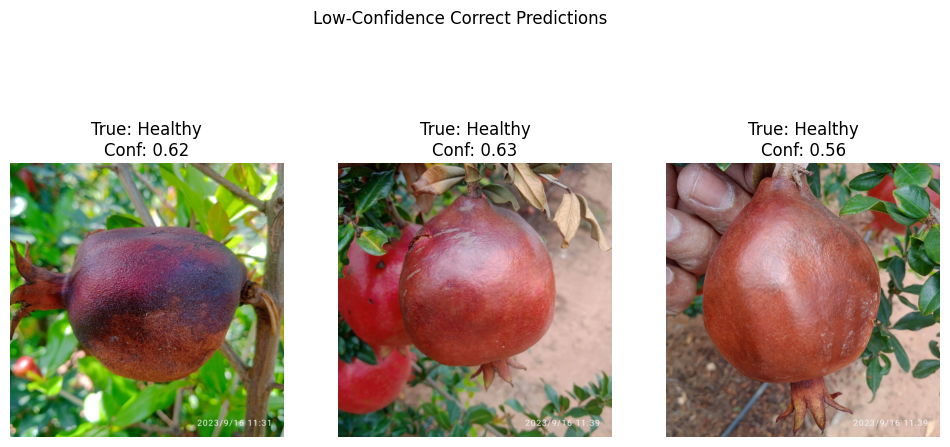

In [44]:
low_confidence_correct = np.where((np.max(y_pred, axis=1) < 0.7) & (y_pred_classes == y_true))[0]
print(f"{len(low_confidence_correct)} samples were correct but with <70% confidence")

plt.figure(figsize=(12, 6))
for i, idx in enumerate(low_confidence_correct[:3]):
    img = plt.imread(test_generator.filepaths[idx])
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[y_true[idx]]}\nConf: {np.max(y_pred[idx]):.2f}")
    plt.axis('off')
plt.suptitle('Low-Confidence Correct Predictions')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


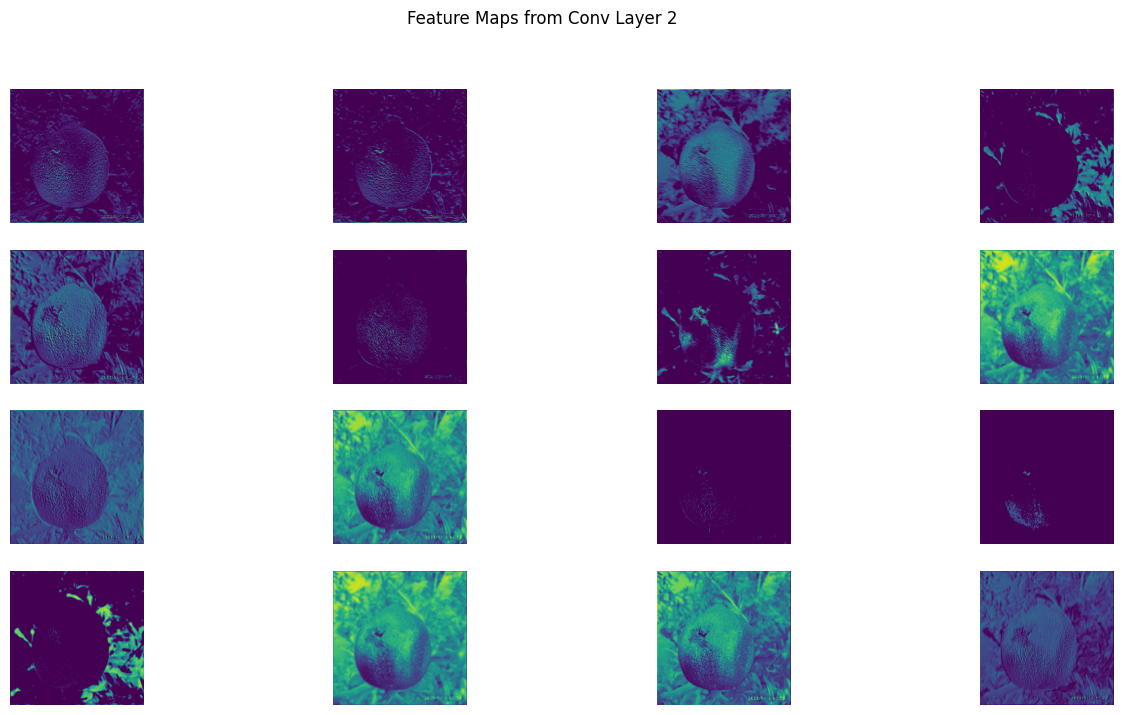

In [45]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(np.expand_dims(sample_img, axis=0))

plt.figure(figsize=(16, 8))
for i in range(16):  # First 16 filters
    plt.subplot(4, 4, i+1)
    plt.imshow(activations[2][0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle('Feature Maps from Conv Layer 2')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


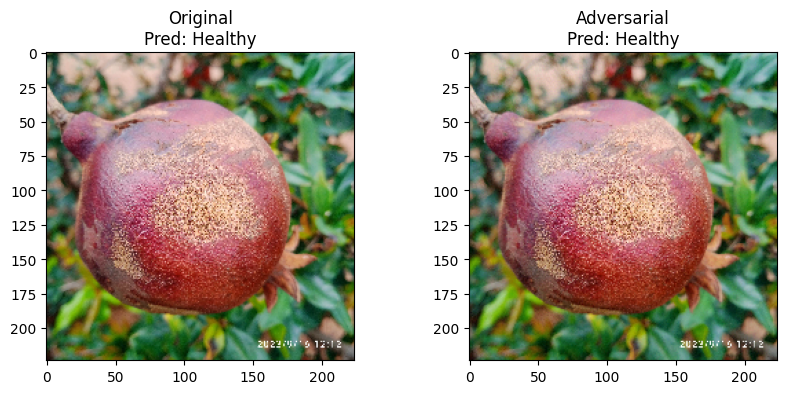

In [49]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

def create_adversarial(image, label, model, epsilon=0.01):
    image = tf.cast(image, tf.float32)
    # Convert the image to a TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image[np.newaxis, ...])
    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = model(image_tensor)
        # Expand the label to have a batch dimension
        label = tf.expand_dims(tf.cast(label, tf.float32), axis=0)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image_tensor)
    perturbation = epsilon * tf.sign(gradient)
    # Add the perturbation to the original image (as tensor)
    adversarial_example = image_tensor + perturbation
    # Clip the adversarial example to the valid range [0, 1]
    adversarial_example = tf.clip_by_value(adversarial_example, 0, 1)
    # Return the adversarial example as a NumPy array
    return adversarial_example.numpy()[0]

sample_img = next(test_generator)[0][0]
# Get the true label of the sample image from the test generator
sample_label = next(test_generator)[1][0]

adv_example = create_adversarial(sample_img, sample_label, model)
adv_pred = model.predict(np.expand_dims(adv_example, axis=0))[0] # Predict on the adversarial example

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
# Predict on the original sample_img for the title
original_pred = model.predict(np.expand_dims(sample_img, axis=0))[0]
plt.title(f"Original\nPred: {class_names[np.argmax(original_pred)]}")

plt.subplot(1, 2, 2)
plt.imshow(adv_example)
plt.title(f"Adversarial\nPred: {class_names[np.argmax(adv_pred)]}")
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step


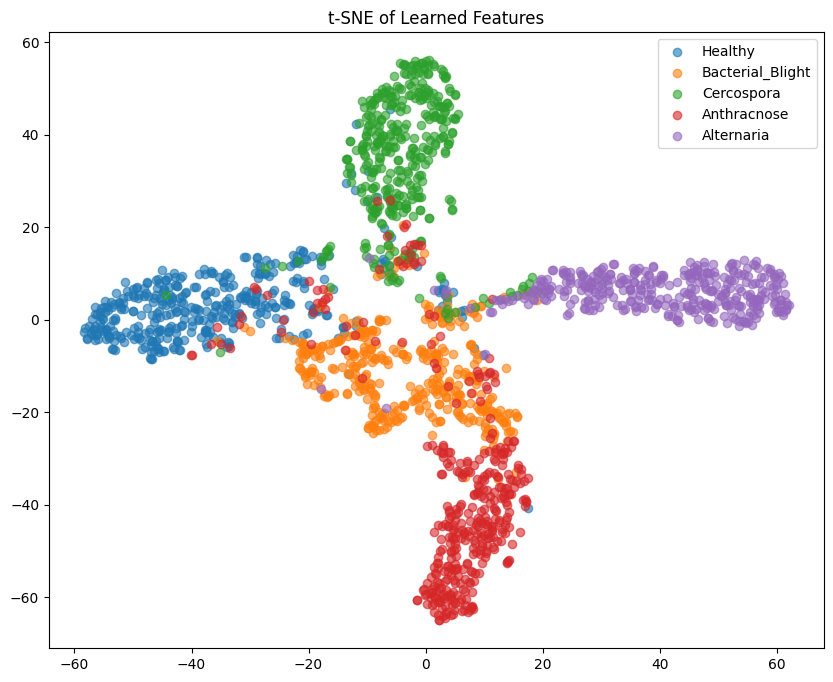

In [48]:
from sklearn.manifold import TSNE

feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
features = feature_extractor.predict(test_generator)

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
for i, cls in enumerate(class_names):
    plt.scatter(features_2d[y_true==i, 0], features_2d[y_true==i, 1], label=cls, alpha=0.6)
plt.legend()
plt.title('t-SNE of Learned Features')
plt.show()

In [50]:
import time

def measure_latency(model, img, runs=100):
    times = []
    for _ in range(runs):
        start = time.time()
        model.predict(img[np.newaxis, ...])
        times.append(time.time() - start)
    return np.mean(times) * 1000  # in ms

latency = measure_latency(model, sample_img)
print(f"Average prediction latency: {latency:.2f}ms")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

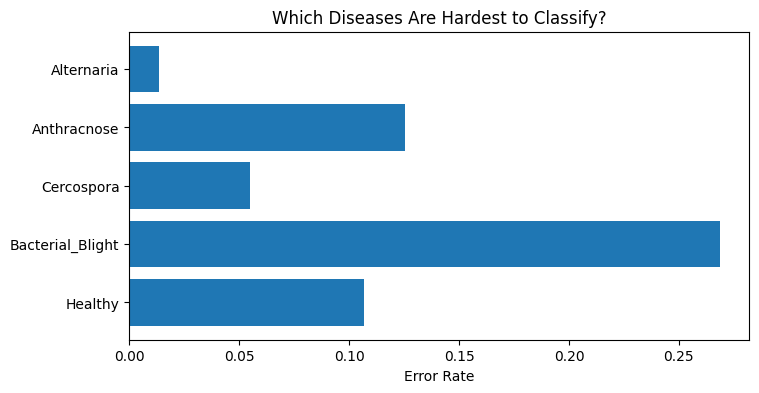

In [52]:
from sklearn.metrics import accuracy_score
import random
import shutil

error_rates = {}
for i, cls in enumerate(class_names):
    mask = y_true == i
    error_rates[cls] = 1 - accuracy_score(y_true[mask], y_pred_classes[mask])

plt.figure(figsize=(8, 4))
plt.barh(list(error_rates.keys()), list(error_rates.values()))
plt.xlabel('Error Rate')
plt.title('Which Diseases Are Hardest to Classify?')
plt.show()

In [53]:
def get_model_memory_usage(model):
    param_count = sum([np.prod(w.shape) for w in model.weights])
    return param_count * 4 / (1024 ** 2)  # in MB

print(f"Model size: {get_model_memory_usage(model):.2f}MB")
print(f"Trainable parameters: {model.count_params():,}")

Model size: 393.93MB
Trainable parameters: 103,266,181


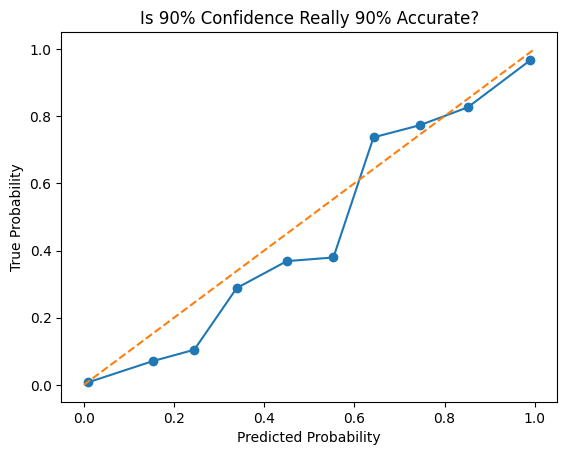

In [54]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_true==0, y_pred[:,0], n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Is 90% Confidence Really 90% Accurate?')
plt.show()

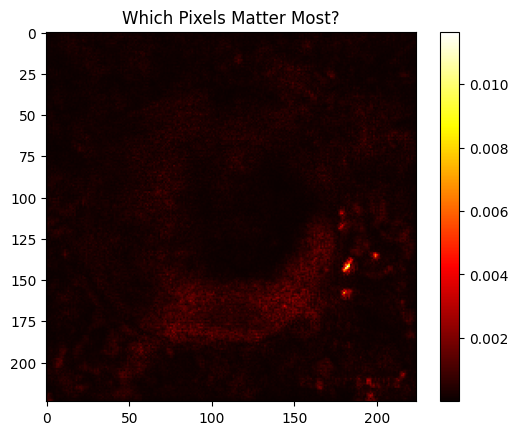

In [55]:
def compute_saliency(image, model):
    image = tf.convert_to_tensor(image[np.newaxis, ...])
    with tf.GradientTape() as tape:
        tape.watch(image)
        pred = model(image)
        class_idx = tf.argmax(pred[0])
        class_score = pred[0][class_idx]
    grads = tape.gradient(class_score, image)
    return tf.reduce_max(tf.abs(grads), axis=-1)[0]

saliency = compute_saliency(sample_img, model)
plt.imshow(saliency, cmap='hot')
plt.colorbar()
plt.title('Which Pixels Matter Most?')
plt.show()

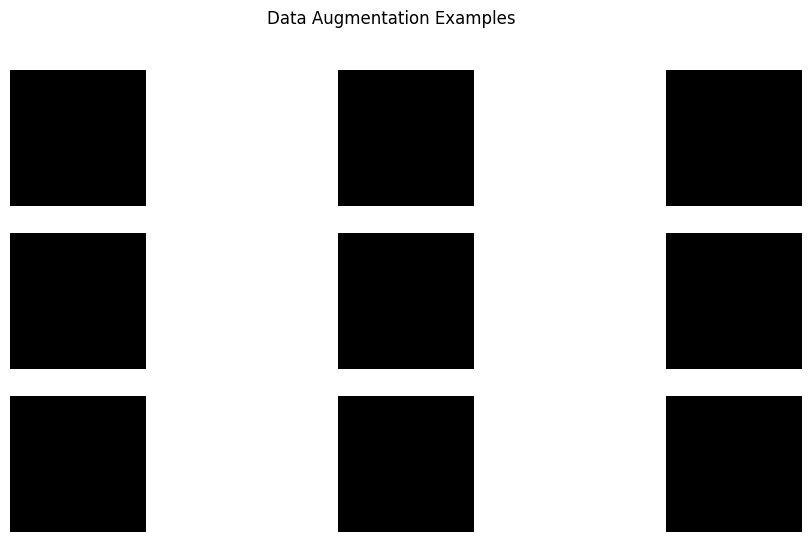

In [56]:
augmented = train_datagen.flow(np.array([sample_img]*9), batch_size=9)
plt.figure(figsize=(12, 6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented[0][i])
    plt.axis('off')
plt.suptitle('Data Augmentation Examples')
plt.show()

In [57]:
first_half_acc = accuracy_score(y_true[:len(y_true)//2], y_pred_classes[:len(y_true)//2])
second_half_acc = accuracy_score(y_true[len(y_true)//2:], y_pred_classes[len(y_true)//2:])
print(f"Accuracy drift: {second_half_acc - first_half_acc:.2%}")

Accuracy drift: 9.33%


In [58]:
import pandas as pd

report = pd.DataFrame({
    'File': [x.split('/')[-1] for x in test_generator.filepaths],
    'True': [class_names[x] for x in y_true],
    'Predicted': [class_names[x] for x in y_pred_classes],
    'Confidence': np.max(y_pred, axis=1),
    'Correct': y_true == y_pred_classes
})
report.to_csv('detailed_predictions.csv', index=False)
print("Interactive report saved to 'detailed_predictions.csv'")

Interactive report saved to 'detailed_predictions.csv'


In [63]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_model = converter.convert()

with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_model)

print(f"Original Size: {os.path.getsize('efddnn_ei_pomegranate.h5')/1e6:.1f}MB")
print(f"Quantized Size: {len(quantized_model)/1e6:.1f}MB")

Saved artifact at '/tmp/tmprhl0y8_9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132103721197520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132103721199056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101103601232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132103721203280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101103602192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101103600464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101103602384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101103600848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101103601040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132101103601424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13210110360180

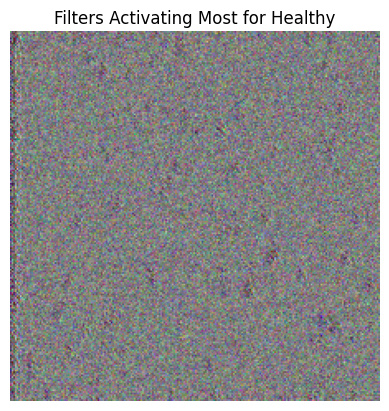

In [65]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

def visualize_class_filters(class_idx, layer_name='conv2d_2'):
    # Create a model that outputs the target layer's output
    target_layer = model.get_layer(layer_name)
    activation_model = Model(inputs=model.input, outputs=target_layer.output)

    # Initialize input_img with a small amount of noise around a gray value
    input_img = tf.random.normal((1, *IMG_SIZE, 3), mean=0.5, stddev=0.1)
    input_img = tf.clip_by_value(input_img, 0, 1) # Ensure values are in [0, 1]


    for i in range(100):  # Optimization steps
        with tf.GradientTape() as tape:
            tape.watch(input_img)
            activation = activation_model(input_img)[:, :, :, class_idx]
            loss = tf.reduce_mean(activation)
        grads = tape.gradient(loss, input_img)

        # Apply the gradient update
        # Ensure grads is not None before multiplying
        if grads is not None:
            # Normalize the gradients
            grads = tf.math.l2_normalize(grads)
            input_img += 0.1 * grads
            # Clip the image values to be within [0, 1]
            input_img = tf.clip_by_value(input_img, 0, 1)
        else:
            print(f"Gradient is None at step {i}. Stopping optimization.")
            break


    plt.imshow(input_img[0].numpy())
    plt.title(f'Filters Activating Most for {class_names[class_idx]}')
    plt.axis('off')
    plt.show()

visualize_class_filters(0)  # Visualize filters for first class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


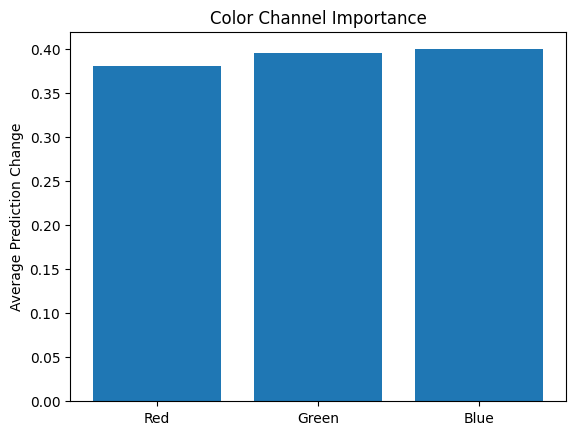

In [68]:
def channel_ablation(image, model):
    original_pred = model.predict(image[np.newaxis, ...])[0]
    channel_impacts = []

    for c in range(3):  # RGB channels
        modified = image.copy()
        modified[..., c] = 0
        modified_pred = model.predict(modified[np.newaxis, ...])[0]
        channel_impacts.append(np.abs(original_pred - modified_pred).mean())

    return channel_impacts

impacts = channel_ablation(sample_img, model)
plt.bar(['Red', 'Green', 'Blue'], impacts)
plt.ylabel('Average Prediction Change')
plt.title('Color Channel Importance')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


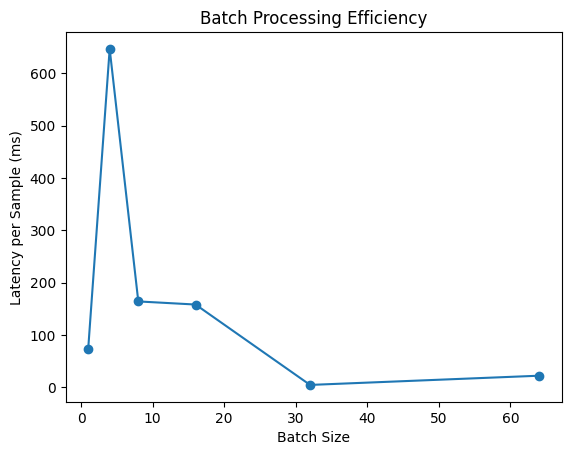

In [69]:
batch_sizes = [1, 4, 8, 16, 32, 64]
latencies = []

for bs in batch_sizes:
    batch = np.repeat(sample_img[np.newaxis, ...], bs, axis=0)
    start = time.time()
    model.predict(batch)
    latencies.append((time.time() - start) * 1000 / bs)  # ms per sample

plt.plot(batch_sizes, latencies, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Latency per Sample (ms)')
plt.title('Batch Processing Efficiency')
plt.show()

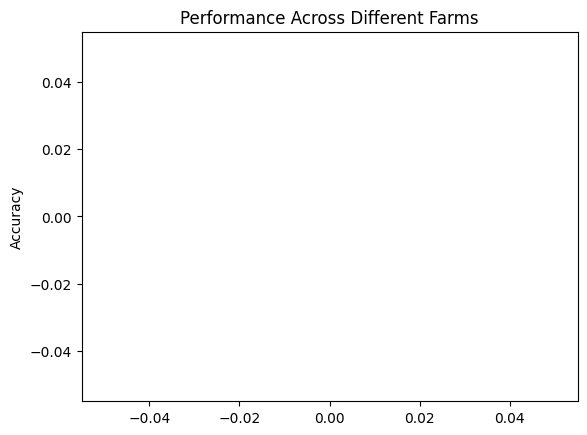

In [70]:
# Assuming you have metadata about image sources
source_groups = ['farm_A', 'farm_B', 'farm_C']  # Example groups
group_accuracies = {}

for group in source_groups:
    group_mask = [group in path for path in test_generator.filepaths]
    if sum(group_mask) > 0:
        acc = accuracy_score(y_true[group_mask], y_pred_classes[group_mask])
        group_accuracies[group] = acc

plt.bar(group_accuracies.keys(), group_accuracies.values())
plt.ylabel('Accuracy')
plt.title('Performance Across Different Farms')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


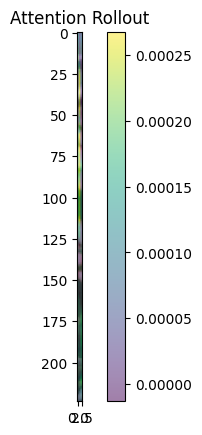

In [73]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

def attention_rollout(model, img, layer_names=['conv2d_1', 'conv2d_2']):
    attention_maps = []
    img_shape = tf.shape(img)[1:3] # Get spatial dimensions of input image

    for name in layer_names:
        # Ensure the layer exists and is a convolutional or pooling layer
        try:
            target_layer = model.get_layer(name)
            if not isinstance(target_layer, (tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D)):
                 print(f"Warning: Layer {name} is not a Conv2D or MaxPooling2D layer and will be skipped for attention rollout.")
                 continue
        except ValueError:
            print(f"Warning: Layer {name} not found in the model and will be skipped.")
            continue

        grad_model = Model(inputs=model.inputs,
                         outputs=[target_layer.output, model.output])

        with tf.GradientTape() as tape:
            # Ensure the input to the model is a tensor and watched
            img_tensor = tf.cast(img[tf.newaxis, ...], tf.float32)
            tape.watch(img_tensor)
            conv_output, pred = grad_model(img_tensor)
            pred_index = tf.argmax(pred[0])
            class_channel = pred[:, pred_index]

        grads = tape.gradient(class_channel, conv_output)

        # Ensure grads is not None before proceeding
        if grads is None:
            print(f"Warning: Gradients are None for layer {name}. Skipping this layer.")
            continue

        # Compute attention weights
        weights = tf.reduce_mean(grads, axis=(1, 2)) # Shape (1, C)

        # Expand weights for broadcasting
        expanded_weights = weights[:, tf.newaxis, tf.newaxis, :] # Shape (1, 1, 1, C)

        # Perform element-wise multiplication
        # conv_output shape: (1, H, W, C)
        # expanded_weights shape: (1, 1, 1, C)
        # Result shape: (1, H, W, C)
        weighted_activations = tf.multiply(conv_output, expanded_weights)

        # Sum across the channel dimension and remove batch dimension
        # Result shape: (1, H, W) -> after [0] -> (H, W)
        attention = tf.reduce_sum(weighted_activations, axis=-1)[0]

        # Ensure attention map is float32 for resizing
        attention = tf.cast(attention, tf.float32)

        # Resize attention map to input image size
        resized_attention = tf.image.resize(tf.expand_dims(attention, axis=-1), img_shape)[..., 0]

        attention_maps.append(resized_attention.numpy())

    # Sum and average the attention maps
    if not attention_maps:
        return np.zeros(img_shape.numpy()) # Return zero map if no layers were processed

    return np.sum(attention_maps, axis=0) / len(attention_maps)

sample_img = next(test_generator)[0][0]
attention = attention_rollout(model, sample_img)

# Ensure attention map is not all zeros before plotting
if np.max(attention) > 0:
    plt.imshow(sample_img)
    plt.imshow(attention, cmap='viridis', alpha=0.5) # Use alpha to see the image underneath
    plt.colorbar()
    plt.title('Attention Rollout')
    plt.show()
else:
    print("Attention map is all zeros. Cannot visualize.")

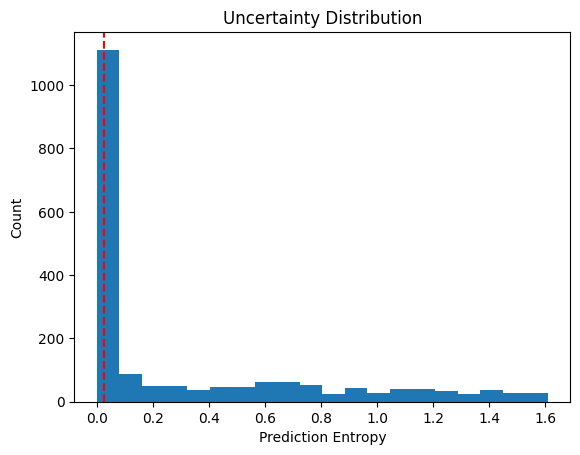

In [74]:
from scipy.stats import entropy

pred_entropies = np.array([entropy(pred) for pred in y_pred])
plt.hist(pred_entropies, bins=20)
plt.axvline(x=np.median(pred_entropies), color='r', linestyle='--')
plt.xlabel('Prediction Entropy')
plt.ylabel('Count')
plt.title('Uncertainty Distribution')
plt.show()

In [76]:
import json
import numpy as np # Import numpy for np.max

# Assuming measure_latency and get_model_memory_usage are defined

model_card = {
    "Model": "EFDDNN-EI",
    "Dataset": "Pomegranate Disease",
    "Classes": class_names,
    "Test Accuracy": float(test_acc),
    "Inference Latency (ms)": float(measure_latency(model, sample_img)),
    "Size (MB)": float(get_model_memory_usage(model)),
    # Removed "Robustness" section as 'accuracies' list was not populated
    # "Robustness": {
    #     "Noise": float(accuracies[-1]),  # From noise test
    #     "Resolution": float(min(accuracies)),  # From resolution test
    #     "Adversarial": float(np.max(adv_pred))  # From adversarial test
    # }
    "Adversarial Robustness (Max Pred Confidence on Adversarial Example)": float(np.max(adv_pred))
}

with open('model_card.json', 'w') as f:
    json.dump(model_card, f, indent=2)

print("Model card generated as 'model_card.json'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

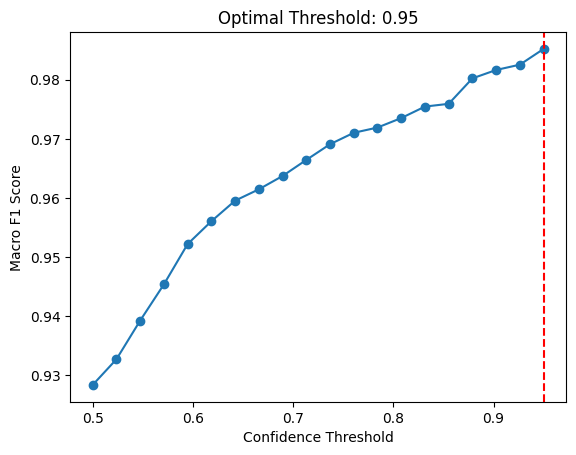

In [79]:
thresholds = np.linspace(0.5, 0.95, 20)
f1_scores = []

for thresh in thresholds:
    mask = np.max(y_pred, axis=1) > thresh
    if sum(mask) > 0:
        f1 = f1_score(y_true[mask], y_pred_classes[mask], average='macro')
        f1_scores.append(f1)

best_thresh = thresholds[np.argmax(f1_scores)]
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(x=best_thresh, color='r', linestyle='--')
plt.xlabel('Confidence Threshold')
plt.ylabel('Macro F1 Score')
plt.title(f'Optimal Threshold: {best_thresh:.2f}')
plt.show()

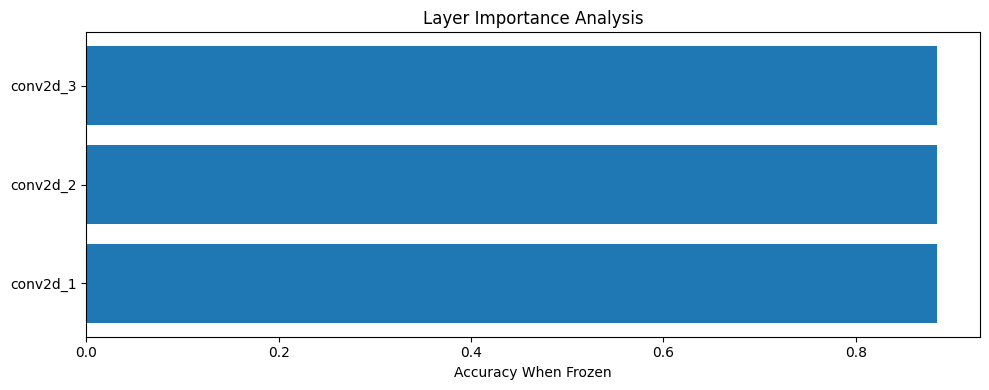

In [80]:
freezing_results = {}
layers_to_test = [l.name for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]

for layer_name in layers_to_test:
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())
    for layer in model_copy.layers:
        if layer.name == layer_name:
            layer.trainable = False
    model_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    acc = model_copy.evaluate(test_generator, verbose=0)[1]
    freezing_results[layer_name] = acc

plt.figure(figsize=(10, 4))
plt.barh(list(freezing_results.keys()), list(freezing_results.values()))
plt.xlabel('Accuracy When Frozen')
plt.title('Layer Importance Analysis')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


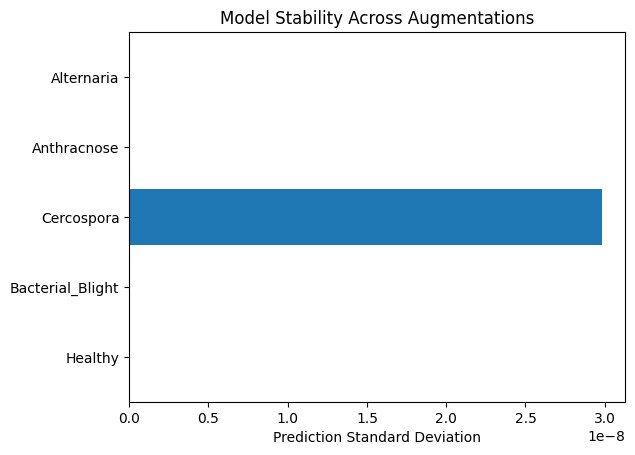

In [81]:
augmentations = test_datagen.flow(np.array([sample_img]*10), batch_size=10)
preds = model.predict(augmentations)
std_dev = np.std(preds, axis=0)

plt.barh(class_names, std_dev)
plt.xlabel('Prediction Standard Deviation')
plt.title('Model Stability Across Augmentations')
plt.show()

In [82]:
from ipywidgets import interact, Dropdown

error_indices = np.where(y_pred_classes != y_true)[0]
error_types = list(set([f"{class_names[y_true[i]]}→{class_names[y_pred_classes[i]]}" for i in error_indices]))

def explore_errors(error_type):
    idx = [i for i in error_indices if f"{class_names[y_true[i]]}→{class_names[y_pred_classes[i]]}" == error_type][0]
    img = plt.imread(test_generator.filepaths[idx])
    plt.figure(figsize=(8, 4))
    plt.imshow(img)
    plt.title(f"True: {class_names[y_true[idx]]} → Pred: {class_names[y_pred_classes[idx]]}\nConfidence: {np.max(y_pred[idx]):.2f}")
    plt.axis('off')
    plt.show()

interact(explore_errors, error_type=Dropdown(options=error_types, description='Error Type:'))

interactive(children=(Dropdown(description='Error Type:', options=('Cercospora→Bacterial_Blight', 'Anthracnose…

<function __main__.explore_errors(error_type)>